## CNN Models Step by Step Implementation

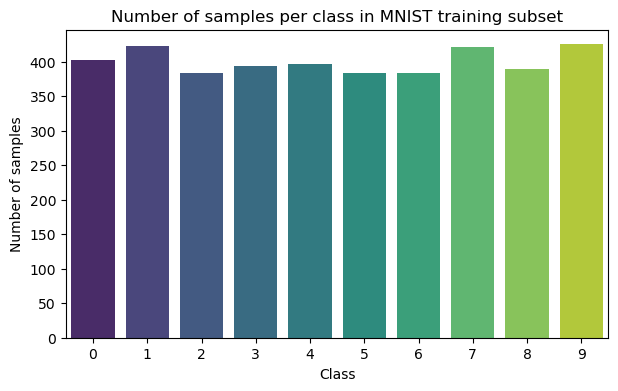

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense

# any random process will produce same results every time its run
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load MNIST dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

""" 
subset 
replace=False -> randomly selected indices are unique
"""
indices_train = np.random.choice(len(x_train_full), 4000, replace=False)
indices_test = np.random.choice(len(x_test_full), 1000, replace=False)

# Save this exact random subset for other models
np.save('indices_train.npy', indices_train)
np.save('indices_test.npy', indices_test)

#Init sets and labels
x_train, y_train = x_train_full[indices_train], y_train_full[indices_train]
x_test, y_test = x_test_full[indices_test], y_test_full[indices_test]

# number of samples per class 
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot samples per class 
plt.figure(figsize=(7, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class in MNIST training subset')
plt.xticks(np.arange(10), [str(i) for i in range(10)])  
plt.show()
plt.close()

In [3]:
"""
Preprocess: 
- add channel dimension for greyscale images
- scale pixels into range [0,1]
"""
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2326 - f1_score: 9.9337e-04 - loss: 2.1764 - precision: 0.2241 - recall: 6.2174e-04 - val_accuracy: 0.7325 - val_f1_score: 0.1102 - val_loss: 1.4262 - val_precision: 1.0000 - val_recall: 0.0750
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - f1_score: 0.3500 - loss: 1.1250 - precision: 0.9462 - recall: 0.2803 - val_accuracy: 0.8225 - val_f1_score: 0.7589 - val_loss: 0.5958 - val_precision: 0.9201 - val_recall: 0.7200
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - f1_score: 0.8129 - loss: 0.5422 - precision: 0.9273 - recall: 0.7570 - val_accuracy: 0.8675 - val_f1_score: 0.8214 - val_loss: 0.4540 - val_precision: 0.9233 - val_recall: 0.8125
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8876 - f1_score: 0.8641 - loss: 0.4109 - precision: 0.9331 - recall: 0.8290 - val_accuracy: 0.8650 - val_f1_score: 0.8497 - val_loss: 0.4116 - val_precision: 0.9160 - val_recall: 0.8

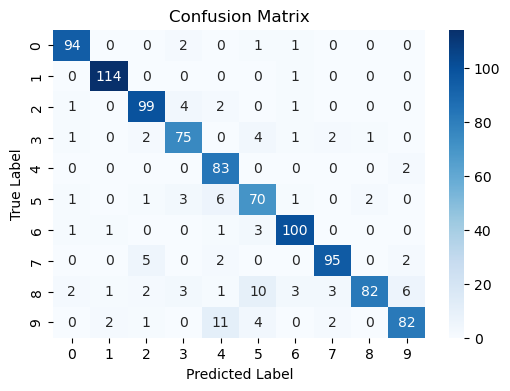

In [4]:
#random seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Basic model
basic_model = models.Sequential()
basic_model.add(Input(shape=(28, 28, 1)))
basic_model.add(layers.Conv2D(1, (5, 5), activation='relu'))
basic_model.add(layers.MaxPooling2D((2, 2)))
basic_model.add(layers.Flatten())
basic_model.add(layers.Dense(64, activation='relu'))
basic_model.add(layers.Dense(10, activation='softmax'))


#calc f1-score 
def f1_score(y_true, y_pred):
    
    """
    round prediction to 0 or 1 (predicted probabilities for each class)
    y_pred is a tensor of shape (batch_size := num of samples, num_classes)
    each row sums up to 1 (all pedictions for one class)
    """
    y_pred = K.round(y_pred) # K belongs to keras backend and helps operating tensor operations
    
    """
    tp = true positives
    y_true has one "1" per row (sample only belongs to one class)
    only tp if y_true = y_pred = 1
    """
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    
    #fp = false positive
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    
    #fn = false negatives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    
    """
    #precision: proportion of true positives amongst all positives predictions 
    How many of the positive detections were actually correct?
    - High precision: low error rate in predicting positives correctly
    #K.epsilon() avoids devision by zero
    """
    p = tp / (tp + fp + K.epsilon())
    
    
    #proportion of true positives 
    #recall: proportion of tp of all positive instances (how many of the positives were detected?)
    r = tp / (tp + fn + K.epsilon())
    
    #f1-score unites precision and recall in a harmonic mean (type of average)
    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)

"""
Categorial cross-entropy: L = - sum(yi log(y'i))
where i is one of n classes, yi is the true label and y'i is the prediction 
"""
basic_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])


"""
Train: algorithm is run 5 times through entire training set, 
#One backpropagation operation (forward and backward pass) is done with 64 training samples
#10% of the training set used as validation set 
"""
history = basic_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = basic_model.evaluate(x_test, y_test)
metric_names = basic_model.metrics_names

# Print results
for m, val in zip(metric_names, metrics):
    print(f'{m}: {val}')

# Predict the labels 
y_pred = basic_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()


In [5]:
""" 
changed filters of the convolutional layer 
from (1, (5,5)) to (64, (3,3)) -> great improvement
"""
# random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print 
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5603 - f1_score: 0.3177 - loss: 1.4029 - precision_1: 0.8473 - recall_1: 0.2886 - val_accuracy: 0.8925 - val_f1_score: 0.8499 - val_loss: 0.3520 - val_precision_1: 0.9253 - val_recall_1: 0.8675
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9155 - f1_score: 0.9029 - loss: 0.2937 - precision_1: 0.9424 - recall_1: 0.8941 - val_accuracy: 0.9075 - val_f1_score: 0.8825 - val_loss: 0.2726 - val_precision_1: 0.9421 - val_recall_1: 0.8950
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9442 - f1_score: 0.9329 - loss: 0.2023 - precision_1: 0.9577 - recall_1: 0.9253 - val_accuracy: 0.9150 - val_f1_score: 0.8746 - val_loss: 0.2338 - val_precision_1: 0.9378 - val_recall_1: 0.9050
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9666 - f1_score: 0.9589 - loss: 0.1354 - precision_1: 0.9763 - recall_1: 0.9549 - val_accuracy: 0.9300 - val_f1_score: 0.9037 - val_loss: 0.2082 - val_precision_1: 0

In [6]:
""" 
adding another convolutional layer with filters (64, (3,3)) + pooling -> improvement
"""
# random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print 
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5


C:\Users\bende\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4910 - auc: 0.8310 - f1_score: 0.2276 - loss: 1.6027 - precision_2: 0.7066 - recall_2: 0.2120 - val_accuracy: 0.9050 - val_auc: 0.9918 - val_f1_score: 0.8751 - val_loss: 0.3274 - val_precision_2: 0.9318 - val_recall_2: 0.8875
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9201 - auc: 0.9937 - f1_score: 0.9125 - loss: 0.2673 - precision_2: 0.9439 - recall_2: 0.9019 - val_accuracy: 0.9200 - val_auc: 0.9960 - val_f1_score: 0.8817 - val_loss: 0.2267 - val_precision_2: 0.9282 - val_recall_2: 0.9050
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9479 - auc: 0.9965 - f1_score: 0.9438 - loss: 0.1738 - precision_2: 0.9613 - recall_2: 0.9408 - val_accuracy: 0.9350 - val_auc: 0.9968 - val_f1_score: 0.9028 - val_loss: 0.2066 - val_precision_2: 0.9373 - val_recall_2: 0.9350
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9676 - auc: 0.9979 - f1_score: 0.9627 - loss: 0.1145 - precision_2: 0.9765 -

In [7]:
""" 
adding a third convolutonional layer with filter of size 3x3 + pooling layer 
-> decline in performance for different combinations -> decline changes
"""
# random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print 
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3167 - f1_score: 0.0373 - loss: 2.0671 - precision_3: 0.4219 - recall_3: 0.0325 - val_accuracy: 0.7950 - val_f1_score: 0.6793 - val_loss: 0.6591 - val_precision_3: 0.9187 - val_recall_3: 0.6500
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8266 - f1_score: 0.7749 - loss: 0.5817 - precision_3: 0.9063 - recall_3: 0.7299 - val_accuracy: 0.8800 - val_f1_score: 0.8531 - val_loss: 0.3302 - val_precision_3: 0.9191 - val_recall_3: 0.8525
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9061 - f1_score: 0.8811 - loss: 0.3121 - precision_3: 0.9326 - recall_3: 0.8673 - val_accuracy: 0.9000 - val_f1_score: 0.8791 - val_loss: 0.2899 - val_precision_3: 0.9237 - val_recall_3: 0.8775
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9266 - f1_score: 0.9139 - loss: 0.2493 - precision_3: 0.9435 - recall_3: 0.9075 - val_accuracy: 0.9200 - val_f1_score: 0.8809 - val_loss: 0.2247 - val_precision_3: 0

In [8]:
""" 
added a dropout layer after each pooling layer and fully connected layer
-> improvement with dropout rate of 25% 
"""
#  random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print 
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3793 - f1_score: 0.1485 - loss: 1.8251 - precision_4: 0.6246 - recall_4: 0.1262 - val_accuracy: 0.8350 - val_f1_score: 0.7912 - val_loss: 0.4871 - val_precision_4: 0.9014 - val_recall_4: 0.7775
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8380 - f1_score: 0.8130 - loss: 0.5045 - precision_4: 0.8917 - recall_4: 0.7811 - val_accuracy: 0.9175 - val_f1_score: 0.8701 - val_loss: 0.2699 - val_precision_4: 0.9349 - val_recall_4: 0.8975
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9191 - f1_score: 0.9089 - loss: 0.2808 - precision_4: 0.9384 - recall_4: 0.8946 - val_accuracy: 0.9200 - val_f1_score: 0.8814 - val_loss: 0.2597 - val_precision_4: 0.9359 - val_recall_4: 0.9125
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9404 - f1_score: 0.9323 - loss: 0.2038 - precision_4: 0.9555 - recall_4: 0.9254 - val_accuracy: 0.9375 - val_f1_score: 0.9065 - val_loss: 0.1877 - val_precision_4

In [9]:
""" 
added zero padding before convolutions with padding='same' -> change in performance are negligible
"""
# random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print results
for na, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3927 - f1_score: 0.1869 - loss: 1.7289 - precision_5: 0.6628 - recall_5: 0.1631 - val_accuracy: 0.8500 - val_f1_score: 0.7783 - val_loss: 0.4323 - val_precision_5: 0.8898 - val_recall_5: 0.7875
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8581 - f1_score: 0.8363 - loss: 0.4591 - precision_5: 0.8928 - recall_5: 0.8083 - val_accuracy: 0.9175 - val_f1_score: 0.8719 - val_loss: 0.2625 - val_precision_5: 0.9352 - val_recall_5: 0.9025
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9187 - f1_score: 0.9102 - loss: 0.2575 - precision_5: 0.9357 - recall_5: 0.8984 - val_accuracy: 0.9150 - val_f1_score: 0.8913 - val_loss: 0.2490 - val_precision_5: 0.9335 - val_recall_5: 0.9125
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9337 - f1_score: 0.9280 - loss: 0.2210 - precision_5: 0.9501 - recall_5: 0.9201 - val_accuracy: 0.9150 - val_f1_score: 0.8894 - val_loss: 0.2234 - val_precision_5

In [10]:
""" 
trying to add a second fully connected layer again with 64 neurons + subsequent dropout layer
-> performance only improved a little bit by adding the seubsequent dropout layer, 
not by adding the additional fully connected layer
"""
#random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print results
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2636 - f1_score: 0.0680 - loss: 2.0319 - precision_6: 0.5491 - recall_6: 0.0525 - val_accuracy: 0.8175 - val_f1_score: 0.7263 - val_loss: 0.6441 - val_precision_6: 0.9175 - val_recall_6: 0.6675
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7321 - f1_score: 0.6534 - loss: 0.8165 - precision_6: 0.8233 - recall_6: 0.5992 - val_accuracy: 0.9050 - val_f1_score: 0.8496 - val_loss: 0.3066 - val_precision_6: 0.9257 - val_recall_6: 0.8725
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8529 - f1_score: 0.8476 - loss: 0.4350 - precision_6: 0.9040 - recall_6: 0.8162 - val_accuracy: 0.9225 - val_f1_score: 0.8787 - val_loss: 0.2283 - val_precision_6: 0.9503 - val_recall_6: 0.9075
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8901 - f1_score: 0.8807 - loss: 0.3411 - precision_6: 0.9217 - recall_6: 0.8612 - val_accuracy: 0.9375 - val_f1_score: 0.9040 - val_loss: 0.2168 - val_precision_6

In [11]:
""" 
20 instead of 5 epochs
"""
#random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
model = models.Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1)


# Evaluate 
metrics = model.evaluate(x_test, y_test)
metric_names = model.metrics_names

# Print results
for n, val in zip(metric_names, metrics):
    print(f'{n}: {val}')

# Predict the labels 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2636 - f1_score: 0.0680 - loss: 2.0319 - precision_7: 0.5491 - recall_7: 0.0525 - val_accuracy: 0.8175 - val_f1_score: 0.7263 - val_loss: 0.6441 - val_precision_7: 0.9175 - val_recall_7: 0.6675
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7321 - f1_score: 0.6534 - loss: 0.8165 - precision_7: 0.8233 - recall_7: 0.5992 - val_accuracy: 0.9050 - val_f1_score: 0.8496 - val_loss: 0.3066 - val_precision_7: 0.9257 - val_recall_7: 0.8725
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8529 - f1_score: 0.8476 - loss: 0.4350 - precision_7: 0.9040 - recall_7: 0.8162 - val_accuracy: 0.9225 - val_f1_score: 0.8787 - val_loss: 0.2283 - val_precision_7: 0.9503 - val_recall_7: 0.9075
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8901 - f1_score: 0.8807 - loss: 0.3411 - precision_7: 0.9217 - recall_7: 0.8612 - val_accuracy: 0.9375 - val_f1_score: 0.9040 - val_loss: 0.2168 - val_precisi

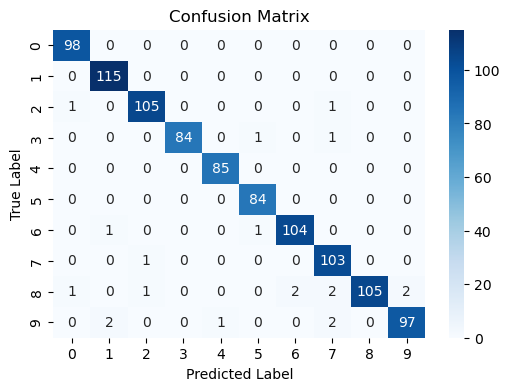

In [12]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## SVM Model Implementation

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.datasets import mnist
import random
import tensorflow as tf

#random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load MNIST
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

# Flatten 
x_train_full = x_train_full.reshape(x_train_full.shape[0], -1)
x_test_full = x_test_full.reshape(x_test_full.shape[0], -1)

#saved indices to use the same data set used for the CNN
indices_train = np.load('indices_train.npy')
indices_test = np.load('indices_test.npy')

# splitting data
X_train, y_train = x_train_full[indices_train], y_train_full[indices_train]
X_test, y_test = x_test_full[indices_test], y_test_full[indices_test]

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#SVM model with default parameters (C=1.0, gamma='scale')
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate 
test_predictions = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='macro')
recall = recall_score(y_test, test_predictions, average='macro')
f1 = f1_score(y_test, test_predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9140
Precision: 0.9155
Recall: 0.9132
F1-Score: 0.9131


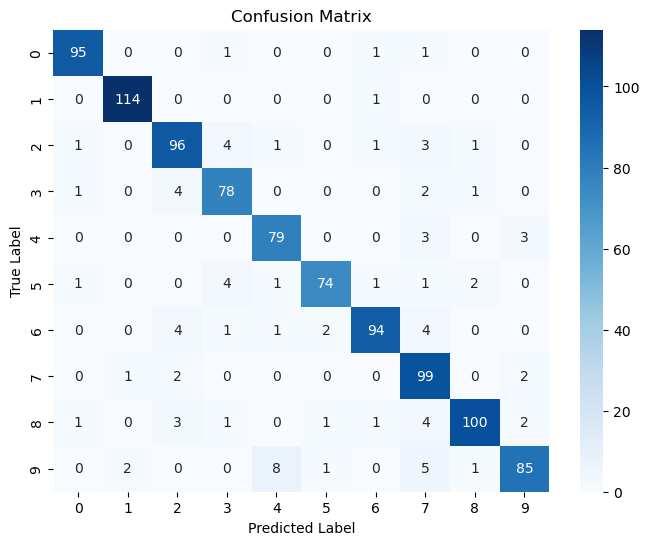

In [14]:
conf_matrix = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Tuned SVM Implementation

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras.datasets import mnist

# random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load MNIST 
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

# Flatten 
x_train_full = x_train_full.reshape(x_train_full.shape[0], -1)
x_test_full = x_test_full.reshape(x_test_full.shape[0], -1)

# saved indices to use the same data set used for the CNN
indices_train = np.load('indices_train.npy')
indices_test = np.load('indices_test.npy')

#splitting data
X_train, y_train = x_train_full[indices_train], y_train_full[indices_train]
X_test, y_test = x_test_full[indices_test], y_test_full[indices_test]

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


"""
parameter grid for C and gamma
'scale' adjusts gamma based on the input data, 
'auto' = 1/n_features
"""
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.0001, 'scale', 'auto']
}
""" 
Init GridSearchCV 
cv=5 := 5-fold-cross-validation 
(datset split into 5 parts and trained 5 times with diff. validation sets)
n_jobs=-1 for using all cpu cores parallel
verbose=2 := print logs of grid search 
"""
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1, verbose=2)

print("Performing grid search...")
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

# Evaluate 
test_predictions = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='macro')
recall = recall_score(y_test, test_predictions, average='macro')
f1 = f1_score(y_test, test_predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performing grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.001}
Accuracy: 0.9360
Precision: 0.9350
Recall: 0.9350
F1-Score: 0.9345


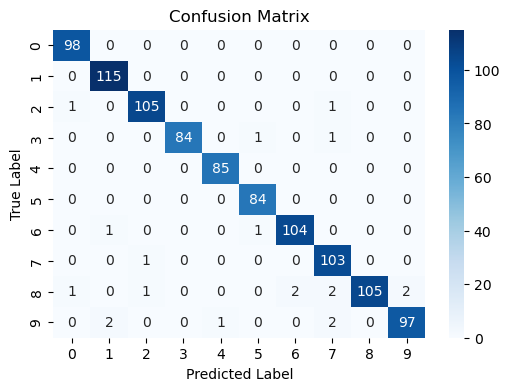

In [16]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## All Comparison Tables

In [17]:
from tabulate import tabulate

data = [
    ["Metric", "Basic CNN", "Enhanced CNN"],
    ["Accuracy", "0.8915", "0.9777"],
    ["F1-Score", "0.8497", "0.9529"],
    ["Precision", "0.9211", "0.9788"],
    ["Recall", "0.8675", "0.9766"],
    ["Loss", "0.3373", "0.1006"],
]

table = tabulate(data, headers="firstrow", tablefmt="grid")
print(table)



+-----------+-------------+----------------+
| Metric    |   Basic CNN |   Enhanced CNN |
+===========+=============+================+
| Accuracy  |      0.8915 |         0.9777 |
+-----------+-------------+----------------+
| F1-Score  |      0.8497 |         0.9529 |
+-----------+-------------+----------------+
| Precision |      0.9211 |         0.9788 |
+-----------+-------------+----------------+
| Recall    |      0.8675 |         0.9766 |
+-----------+-------------+----------------+
| Loss      |      0.3373 |         0.1006 |
+-----------+-------------+----------------+


In [18]:
from tabulate import tabulate

data = [
    ["Metric", "Default SVM", "Tuned SVM"],
    ["Accuracy", "91.40%", "93.60%"],
    ["F1-Score", "91.31%", "93.45%"],
    ["Precision", "91.55%", "93.50%"],
    ["Recall", "91.32%", "93.50%"],
]

table = tabulate(data, headers="firstrow", tablefmt="grid")
print(table)


+-----------+---------------+-------------+
| Metric    | Default SVM   | Tuned SVM   |
+===========+===============+=============+
| Accuracy  | 91.40%        | 93.60%      |
+-----------+---------------+-------------+
| F1-Score  | 91.31%        | 93.45%      |
+-----------+---------------+-------------+
| Precision | 91.55%        | 93.50%      |
+-----------+---------------+-------------+
| Recall    | 91.32%        | 93.50%      |
+-----------+---------------+-------------+


In [19]:
from tabulate import tabulate

data = [
    ["Metric", "Enhanced CNN", "Tuned SVM"],
    ["Accuracy",  "0.9777", "0.9360"],
    ["F1-Score",  "0.9529", "0.9345"],
    ["Precision", "0.9788", "0.9350"],
    ["Recall",  "0.9766", "0.9350"],
]


table = tabulate(data, headers="firstrow", tablefmt="grid")
print(table)



+-----------+----------------+-------------+
| Metric    |   Enhanced CNN |   Tuned SVM |
+===========+================+=============+
| Accuracy  |         0.9777 |      0.936  |
+-----------+----------------+-------------+
| F1-Score  |         0.9529 |      0.9345 |
+-----------+----------------+-------------+
| Precision |         0.9788 |      0.935  |
+-----------+----------------+-------------+
| Recall    |         0.9766 |      0.935  |
+-----------+----------------+-------------+
